In [13]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
df = pd.read_csv("train.csv", encoding = "ISO-8859-1")
df.head()

,id,text,test results,slow internet,troubleshooting,community engagement,gaming,data cap,not related,promotion,...,data analysis,advice,comparison,tech support,seeking recommendations,seeking feedback,payment issues,call to measure,cost comparison,outage
0,176,Today my 1Gbps internet slowed down to 1Mbps. ...,1.0,1.0,1.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,452,"Hello,\nNew here, so I apologize if this has b...",1.0,1.0,1.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,196,"Hi everyone, this has been an ongoing problem ...",1.0,1.0,1.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,652,I recently moved into an apartment with all ut...,1.0,1.0,1.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1070,Hi I'm noticing that my internet today was run...,0.0,1.0,1.0,0.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_toxic = df.drop(['id', 'text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,test results,74.0
1,slow internet,151.0
2,troubleshooting,213.0
3,community engagement,17.0
4,gaming,77.0
5,data cap,2.0
6,not related,69.0
7,promotion,5.0
8,tool,17.0
9,configuration,33.0


Text(0.5, 0, 'category')

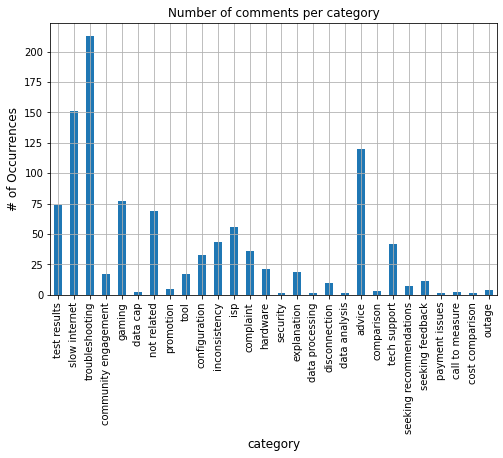

In [15]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

c:\Users\kylie\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '# of categories')

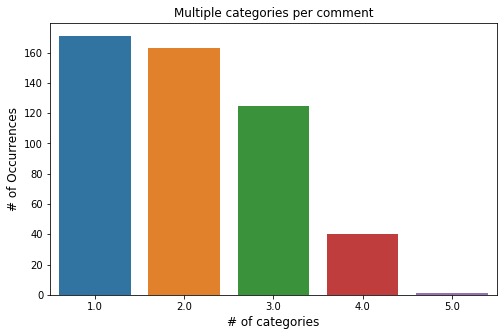

In [16]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [18]:
df['text'] = df['text'].map(lambda com : clean_text(com))
df['text'][0]

'today my 1gbps internet slowed down to 1mbps restarted router pc nothing in the adapter properties its capped at 10mbps but speedtest only shows 1mbps disconnected from my pc to plug in my laptop speedtest shows close to 1gbps tried usb ethernet with my desktop close to 1gbps tried to plug it back back to 1mbps the problem only show up if i use the default ethernet adapter built in pc is 3 years old so its not a super old and yesterday it worked without usb adapter any ideas'

In [19]:
categories = list(df.columns)[2:]
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.text
X_test = test.text
print(X_train.shape)
print(X_test.shape)

(335,)
(165,)


In [20]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(prediction)

... Processing test results
Test accuracy is 0.8363636363636363
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
... Processing slow internet
Test accuracy is 0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.

c:\Users\kylie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(


Test accuracy is 0.7696969696969697
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
... Processing comparison
Test accuracy is 0.9878787878787879
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
... Processing tech support
Test accuracy is 0.9151515151515152
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

https://towardsdatascience.com/how-to-add-new-data-to-a-pretrained-model-in-scikit-learn-ce16911afe33

https://scikit-learn.org/stable/tutorial/basic/tutorial.html

https://www.geeksforgeeks.org/learning-model-building-scikit-learn-python-machine-learning-library/

https://scipy-lectures.org/packages/scikit-learn/index.html